In [1]:
artist_names = ["Eric Clapton", "Jimi Hendrix", "Bob Dylan", "Eagles", "Muddy Waters"]

In [2]:
## download songlyrics.zip from Kaggle, requires log in
## https://www.kaggle.com/mousehead/songlyrics/downloads/songlyrics.zip

## tf from scratch: 
## https://github.com/tensorflow/tensorflow/blob/r1.10/tensorflow/examples/tutorials/word2vec/word2vec_basic.py

In [3]:
import logging
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from gensim.models.word2vec import Word2Vec
from nltk import sent_tokenize, word_tokenize
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from string import punctuation

In [4]:
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [5]:
# data = pd.read_csv('./data/kaggle_lyrics/songlyrics.zip')
# data.drop(columns=['link'], inplace=True)
# data.head()

In [6]:
# ## use kaggle data set on 57,650 songs (check if it has artists for text generation)
# artist_names = ['Eric Clapton', 'Jimi Hendrix', 'Bob Dylan', 'Muddy Waters', 'Eagles']
# for artist_name in artist_names:
#     print('There are {:03d} songs set for {}.'.format(
#         len(data[data['artist'].str.contains(artist_name)]), artist_name))

In [7]:
## add songs from the Genius catalog, for which we'll train the text generating model
data = pd.DataFrame(columns=['artist', 'song', 'text'])
for artist_name in artist_names:
    file_path = './data/lyrics_by_artist/{}.json'.format(
        artist_name.replace(' ',''))
    if os.path.isfile(file_path):
        with open(file_path) as f:
            tmp = json.load(f)
        for i in range(0, len(tmp['artists'][0]['songs'])):
            data = data.append({'artist': artist_name,
                         'song': tmp['artists'][0]['songs'][i]['title'],
                         'text': tmp['artists'][0]['songs'][i]['lyrics']},
                       ignore_index=True)

In [8]:
data.tail()

,artist,song,text
1746,Muddy Waters,You need love - stereo version,"You've got yearnin' and I got burnin'\nBaby, y..."
1747,Muddy Waters,Young Fashioned Ways,\nI may be getting old\nBut I got young-fashio...
1748,Muddy Waters,Young Fashioned Ways (Old-Fashioned Ways),I maybe getting old\nBut I got young fashioned...
1749,Muddy Waters,You're Gonna Need My Help I Said,Well now let me tell you people about a low do...
1750,Muddy Waters,You Shook Me,\nYou know you shook me\nYou shook me all nigh...


In [9]:
%%time
# tokenize lyrics
for i, lyrics in enumerate(data['text']):
    text = lyrics.replace('\n', ' line_break ')
    text = text.split()
    text = [word if word not in punctuation else ' '+word+' ' for word in text]
    text = [word if word != 'line_break' else '\n' for word in text]
    data.loc[i, 'text'] = text

# data['text'] = data['text'].apply(lambda text: word_tokenize(text.replace('\n', '. ')))

CPU times: user 851 ms, sys: 7.35 ms, total: 859 ms
Wall time: 859 ms


In [10]:
data['text'][0]

['\n',
 'I',
 'walked',
 'all',
 'night',
 'long',
 '\n',
 'With',
 'my',
 '32-20',
 'in',
 'my',
 'hand',
 '\n',
 'I',
 'walked',
 'all',
 'night',
 'long',
 '\n',
 'With',
 'my',
 '32-20',
 'in',
 'my',
 'hand',
 '\n',
 'Looking',
 'for',
 'my',
 'woman',
 '\n',
 'Well,',
 'I',
 'found',
 'her',
 'with',
 'another',
 'man',
 '\n',
 '\n',
 'When',
 'I',
 'found',
 'that',
 'woman',
 '\n',
 'They',
 'were',
 'walking',
 'hand',
 'in',
 'hand',
 '\n',
 'When',
 'I',
 'found',
 'that',
 'woman',
 '\n',
 'They',
 'were',
 'walking',
 'hand',
 'in',
 'hand',
 '\n',
 'Well,',
 'it',
 'did',
 'surprise',
 'me',
 '\n',
 'When',
 'I',
 'found',
 'her',
 'with',
 'another',
 'man',
 '\n',
 '\n',
 'She',
 'started',
 'screaming',
 'murder',
 '\n',
 'And',
 'I',
 'had',
 'never',
 'raised',
 'my',
 'hand',
 '\n',
 'She',
 'started',
 'screaming',
 'murder',
 '\n',
 'And',
 'I',
 'had',
 'never',
 'raised',
 'my',
 'hand',
 '\n',
 'Well,',
 'she',
 'knew',
 'that',
 'I',
 'had',
 'them',
 'covered

In [11]:
%%time
## train word2vec nn to generate embeddings
model = Word2Vec(data['text'].tolist(), size=128, window=10, min_count=10, workers=6, sg=0, hs=0)
model.train(data['text'].tolist(), total_examples=len(data['text']), epochs=10)
# note: sg=0,1 (skip gram or cbow by default)
# note: hs=0,1 (hierarchical softmax or negative sampling by default)

model.wv.most_similar(positive=['man', 'cold'], negative=[], topn=5)

2018-09-09 22:12:14,151 : INFO : collecting all words and their counts
2018-09-09 22:12:14,152 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2018-09-09 22:12:14,243 : INFO : collected 21302 word types from a corpus of 430891 raw words and 1751 sentences
2018-09-09 22:12:14,244 : INFO : Loading a fresh vocabulary
2018-09-09 22:12:14,267 : INFO : effective_min_count=10 retains 3046 unique words (14% of original 21302, drops 18256)
2018-09-09 22:12:14,268 : INFO : effective_min_count=10 leaves 390702 word corpus (90% of original 430891, drops 40189)
2018-09-09 22:12:14,278 : INFO : deleting the raw counts dictionary of 21302 items
2018-09-09 22:12:14,279 : INFO : sample=0.001 downsamples 45 most-common words
2018-09-09 22:12:14,279 : INFO : downsampling leaves estimated 262084 word corpus (67.1% of prior 390702)
2018-09-09 22:12:14,288 : INFO : estimated required memory for 3046 words and 128 dimensions: 4642104 bytes
2018-09-09 22:12:14,289 : INFO : resetting

2018-09-09 22:12:15,936 : INFO : EPOCH - 5 : training on 430891 raw words (262206 effective words) took 0.1s, 1803279 effective words/s
2018-09-09 22:12:16,073 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-09-09 22:12:16,078 : INFO : worker thread finished; awaiting finish of 4 more threads
2018-09-09 22:12:16,079 : INFO : worker thread finished; awaiting finish of 3 more threads
2018-09-09 22:12:16,084 : INFO : worker thread finished; awaiting finish of 2 more threads
2018-09-09 22:12:16,085 : INFO : worker thread finished; awaiting finish of 1 more threads
2018-09-09 22:12:16,087 : INFO : worker thread finished; awaiting finish of 0 more threads
2018-09-09 22:12:16,087 : INFO : EPOCH - 6 : training on 430891 raw words (262236 effective words) took 0.1s, 1775210 effective words/s
2018-09-09 22:12:16,239 : INFO : worker thread finished; awaiting finish of 5 more threads
2018-09-09 22:12:16,240 : INFO : worker thread finished; awaiting finish of 4 more threads


CPU times: user 9.13 s, sys: 153 ms, total: 9.28 s
Wall time: 2.58 s


/Users/hkarimi/venvs/py36_dev/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


In [12]:
## build vocab and embedding matrix
vocab = list(model.wv.vocab)
embedding_matrix = model.wv[vocab] # shape = [vocab_size, embedding_size]
df = pd.DataFrame(embedding_matrix, index=vocab, columns=[
    'comp'+str(i) for i in range(0, embedding_matrix.shape[1])])
print('{} words picked up.'.format(len(vocab)))

3046 words picked up.


In [13]:
## save vocabulary and embedding matrix
np.save('./data/vocab.npy', vocab)
np.save('./data/embedding_matrix.npy', embedding_matrix)

In [14]:
def find_clustered_embeddings(embeddings, distance_threshold, sample_threshold):
    ''' 
    Find only the closely clustered embeddings. 
    This gets rid of more sparsly distributed word embeddings and make the visualization clearer
    This is useful for t-SNE visualization
    
    distance_threshold: maximum distance between two points to qualify as neighbors
    sample_threshold: number of neighbors required to be considered a cluster
    '''
    
    # calculate cosine similarity
    cosine_sim = np.dot(embeddings,np.transpose(embeddings))
    norm = np.dot(np.sum(embeddings**2,axis=1).reshape(-1,1),np.sum(np.transpose(embeddings)**2,axis=0).reshape(1,-1))
    assert cosine_sim.shape == norm.shape
    cosine_sim /= norm
    
    # make all the diagonal entries zero otherwise this will be picked as highest
    np.fill_diagonal(cosine_sim, -1.0)
    
    argmax_cos_sim = np.argmax(cosine_sim, axis=1)
    mod_cos_sim = cosine_sim
    # find the maximums in a loop to count if there are more than n items above threshold
    for _ in range(sample_threshold-1):
        argmax_cos_sim = np.argmax(cosine_sim, axis=1)
        mod_cos_sim[np.arange(mod_cos_sim.shape[0]),argmax_cos_sim] = -1
    
    max_cosine_sim = np.max(mod_cos_sim,axis=1)

    return np.where(max_cosine_sim>distance_threshold)[0]

In [15]:
%%time
## tsne and visualize
num_embeddings = 4000
selected_embeddings = embedding_matrix[:num_embeddings,:]

tsne = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, verbose=1).fit_transform(
    selected_embeddings)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 3046 samples in 0.010s...
[t-SNE] Computed neighbors for 3046 samples in 1.704s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3046
[t-SNE] Computed conditional probabilities for sample 2000 / 3046
[t-SNE] Computed conditional probabilities for sample 3000 / 3046
[t-SNE] Computed conditional probabilities for sample 3046 / 3046
[t-SNE] Mean sigma: 0.826417
[t-SNE] KL divergence after 250 iterations with early exaggeration: 76.555481
[t-SNE] Error after 2500 iterations: 2.439205
CPU times: user 4min 1s, sys: 14.5 s, total: 4min 16s
Wall time: 4min 17s


In [24]:
print('Pruning the T-SNE embeddings')
# prune the embeddings by getting ones only more than n-many sample above the similarity threshold
# this unclutters the visualization
selected_ids = find_clustered_embeddings(selected_embeddings, 0.2, 5)
tsne_plot = tsne[selected_ids,:]

print('Out of ', num_embeddings, ' samples, ',
      selected_ids.shape[0],' samples were selected by pruning.')

Pruning the T-SNE embeddings
Out of  4000  samples,  136  samples were selected by pruning.


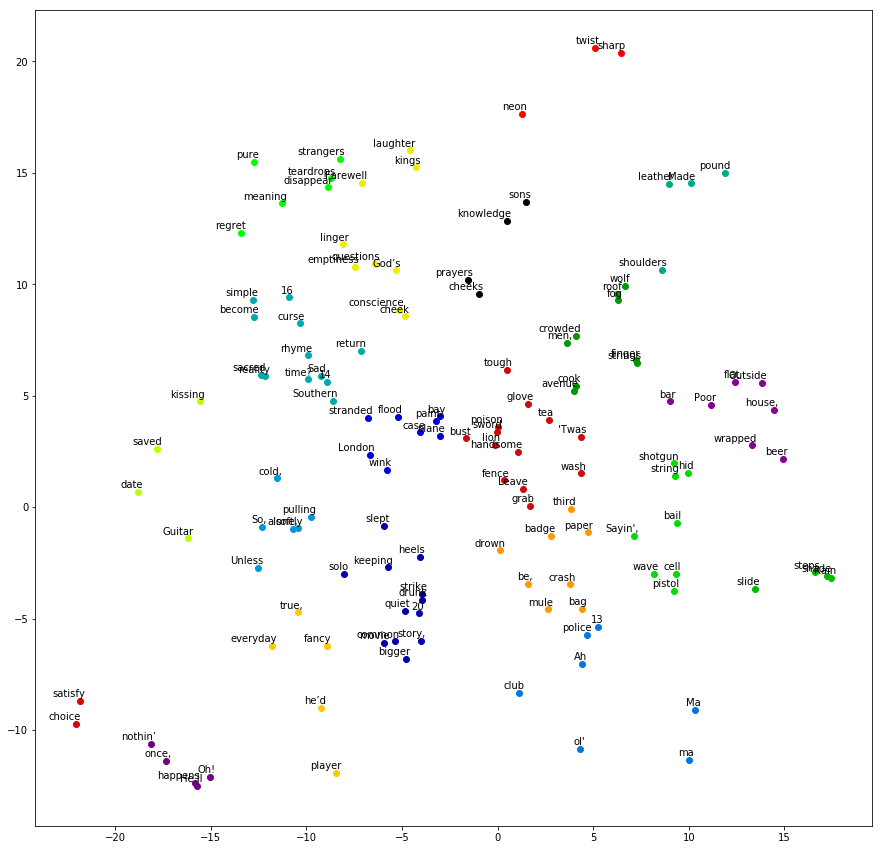

In [25]:
def plot_tsne(embeddings, labels):

    n_clusters = 20 # number of clusters

    # automatically build a discrete set of colors, each for cluster
    color_map = plt.get_cmap('nipy_spectral')
    label_colors = [color_map(float(i)/n_clusters) for i in range(n_clusters)]

    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'

    # Define K-Means
    kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=0).fit(embeddings)
    kmeans_labels = kmeans.labels_

    plt.figure(figsize=(15,15))  # in inches

    # plot all the embeddings and their corresponding words
    for i, (label,klabel) in enumerate(zip(labels,kmeans_labels)):
        x, y = embeddings[i,:]
        plt.scatter(x, y, c=label_colors[klabel])    

        plt.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom',fontsize=10)

    # use for saving the figure if needed
    #plt.savefig('word_embeddings.png')
    plt.show()

vocab_plot = [vocab[i] for i in selected_ids]
plot_tsne(tsne_plot, vocab_plot)